In [ ]:
# Cargar librerias y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion
from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion

from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import random
from collections import defaultdict
import math
from collections import Counter

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('dataset_preprocesado(1).csv')

In [ ]:
df.shape

(15077, 14)

In [ ]:
df.head()

,F03,F04,F06,F07,M01,M02,M03,N01,TARGET,F01_URBANO,F02_EN_VIVIENDA,F02_AGUA_EMBOTELLADA,F05_GLP,F05_LENHA
0,0.0,0.285714,1.0,1.0,2.0,3.0,1.0,-88.0,2.0,1.0,1.0,0.0,1.0,0.0
1,0.0,0.285714,1.0,0.0,2.0,3.0,2.0,-167.0,2.0,1.0,0.0,1.0,1.0,0.0
2,0.0,0.142857,1.0,0.0,1.0,3.0,1.0,-78.0,2.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.285714,2.0,0.0,2.0,2.0,2.0,-27.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.285714,3.0,1.0,3.0,3.0,4.0,-119.0,2.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
df.iloc[:, 10].head()

,F02_EN_VIVIENDA
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0


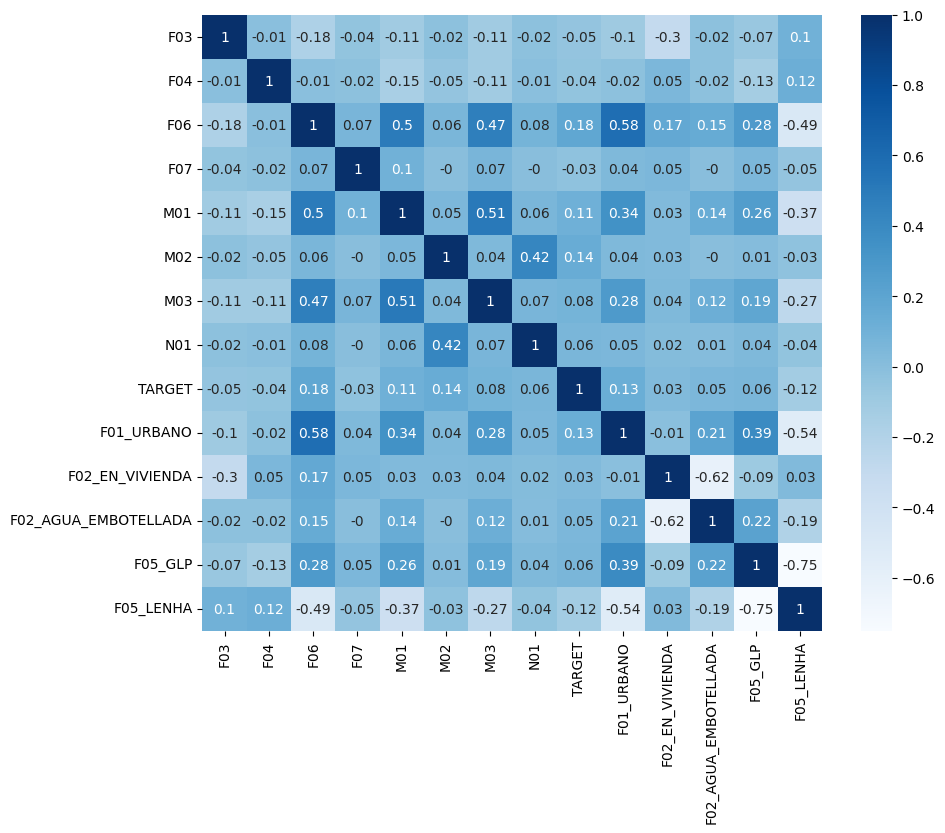

In [ ]:
df_corr = df.corr(numeric_only=True).apply(lambda x: round(x,2))
plt.figure(figsize=(10,8))
sns.heatmap(df_corr,
            annot=True,
            cmap='Blues')
plt.show()

In [ ]:
df['TARGET'].unique()

array([2., 0., 1.])

In [ ]:
df['TARGET'].value_counts()

,count
TARGET,
2.0,10361
1.0,3693
0.0,1023


In [ ]:
(df['TARGET'].value_counts())

,count
TARGET,
2.0,10361
1.0,3693
0.0,1023


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#limpiamos los nulos después d
print("NaN en X:", df.isna().sum().sum())
print("NaN en y:", df.isna().sum())

NaN en X: 0
NaN en y: F03                     0
F04                     0
F06                     0
F07                     0
M01                     0
M02                     0
M03                     0
N01                     0
TARGET                  0
F01_URBANO              0
F02_EN_VIVIENDA         0
F02_AGUA_EMBOTELLADA    0
F05_GLP                 0
F05_LENHA               0
dtype: int64


In [ ]:
df = df.dropna(subset=["N01"])

In [ ]:
X = df.drop('TARGET', axis=1)
y = df['TARGET'].map({0: 1, 1: 2, 2: 3})

# Aplicar SMOTE
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Escalar nuevamente los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

print('Training:', len(y_train), 'ejemplos | Validation:', len(y_test), 'ejemplos')

Training: 24806 ejemplos | Validation: 6202 ejemplos


In [ ]:
print(df.groupby('TARGET').size())

TARGET
0.0     1022
1.0     3689
2.0    10336
dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [ ]:
algos = []

# Random Forest
algos.append(('RandomForest', RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42
)))

# Logistic Regression con distintas configuraciones
algos.append(('LogReg_lbfgs_balanced', LogisticRegression(
    solver='lbfgs', class_weight='balanced', C=1.0, max_iter=10000
)))
algos.append(('LogReg_liblinear_C1.0', LogisticRegression(
    solver='liblinear', class_weight='balanced', C=1.0
)))

# Support Vector Machine (SVM)
algos.append(('SVM_rbf', SVC(
    kernel='rbf', class_weight='balanced', probability=True, random_state=42
)))

# K-Nearest Neighbors (KNN)
algos.append(('KNN_5', KNeighborsClassifier(n_neighbors=5)))

# Gradient Boosting
algos.append(('GradientBoosting', GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, random_state=42
)))

# XGBoost
algos.append(('XGBoost', XGBClassifier(
    n_estimators=100, learning_rate=0.1, random_state=42, scale_pos_weight=1
)))


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
# Definimos el pool de algoritmos de clasificación a evaluar
algos = []
algos.append(('randomForest', RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', random_state=42)))
algos.append(('LogReg_lbfgs_balanced', LogisticRegression(solver='lbfgs', class_weight='balanced', C=1.0, max_iter=10000)))
algos.append(('LogReg_liblinear_C1.0', LogisticRegression(solver='liblinear', class_weight='balanced', C=1.0)))
algos.append(('LogReg_liblinear_C0.1', LogisticRegression(solver='liblinear', class_weight='balanced', C=0.1)))
algos.append(('LogReg_liblinear_C0.01', LogisticRegression(solver='liblinear', class_weight='balanced', C=0.01)))
algos.append(('LogReg_liblinear_C10.0', LogisticRegression(solver='liblinear', class_weight='balanced', C=10.0)))
algos.append(('BalancedRF', BalancedRandomForestClassifier(
    n_estimators=100, random_state=42
)))


In [ ]:
results = []
names = []

seed = 7
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print(f"{algoname}: {cv_results.mean():.6f} ({cv_results.std():.6f})")


randomForest: 0.747027 (0.008079)
LogReg_lbfgs_balanced: 0.430125 (0.008979)
LogReg_liblinear_C1.0: 0.428438 (0.008484)
LogReg_liblinear_C0.1: 0.427638 (0.008735)
LogReg_liblinear_C0.01: 0.426671 (0.007963)
LogReg_liblinear_C10.0: 0.428349 (0.008509)
BalancedRF: 0.748923 (0.008470)


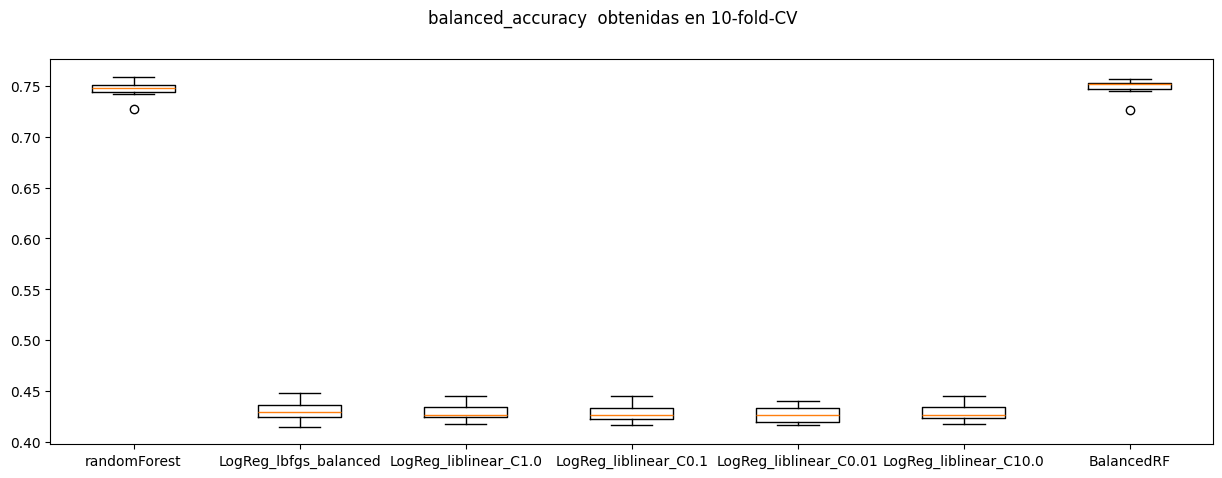

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(15, 5))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
model.fit( X_train, y_train)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_test)
print("Balanced Accuracy score:", balanced_accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_predicted))

Balanced Accuracy score: 0.7437810305132665

Matriz de Confusión:
[[1752  162  153]
 [ 347 1178  542]
 [  48  337 1683]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           1       0.82      0.85      0.83      2067
           2       0.70      0.57      0.63      2067
           3       0.71      0.81      0.76      2068

    accuracy                           0.74      6202
   macro avg       0.74      0.74      0.74      6202
weighted avg       0.74      0.74      0.74      6202



In [ ]:
print("Clases en y_val:", np.unique(y_test))
print("Clases predichas:", np.unique(y_predicted))

Clases en y_val: [1 2 3]
Clases predichas: [1 2 3]


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

# Definimos el pool de pipleines de ML (MinMaxScaler + algoritmo de ML) a evaluar
pipelines = []
pipelines.append(('RandomForest', make_pipeline(RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', random_state=42))))
pipelines.append(('LogReg_lbfgs_balanced', make_pipeline(MinMaxScaler(),LogisticRegression(solver='lbfgs', class_weight='balanced', C=1.0, max_iter=10000))))
pipelines.append(('LogReg_liblinear_C1.0', make_pipeline(MinMaxScaler(),LogisticRegression(solver='liblinear', class_weight='balanced', C=1.0))))
pipelines.append(('LogReg_liblinear_C0.1', make_pipeline(MinMaxScaler(),LogisticRegression(solver='liblinear', class_weight='balanced', C=0.1))))
pipelines.append(('LogReg_liblinear_C0.01', make_pipeline(MinMaxScaler(),LogisticRegression(solver='liblinear', class_weight='balanced', C=0.01))))
pipelines.append(('LogReg_liblinear_C10.0', make_pipeline(MinMaxScaler(),LogisticRegression(solver='liblinear', class_weight='balanced', C=10.0))))
pipelines.append(('RandomForestNONBALA', make_pipeline(BalancedRandomForestClassifier(n_estimators=100, random_state=42))))


In [ ]:
# Evaluamos cada pipeline de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada pipeline en crosvalidacion
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline,X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

KeyboardInterrupt: 

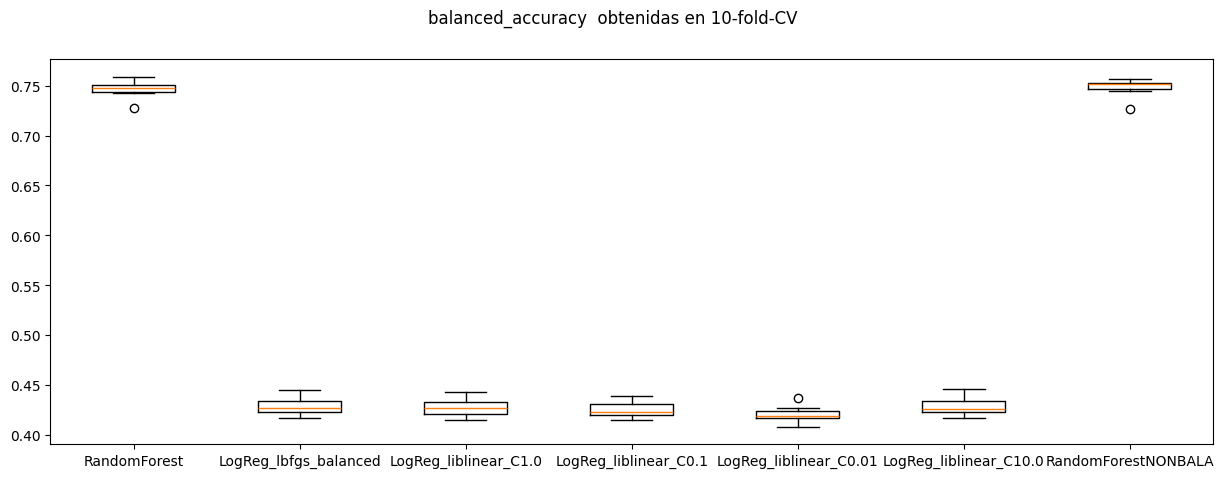

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los pipelines evaluados
fig = plt.figure(figsize=(15, 5))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# Reentrena el pipeline LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
model = make_pipeline(RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', random_state=42))
model.fit(X_train, y_train)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_test)
print("Balanced Accuracy score:", balanced_accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion:\n")
print(classification_report(y_test, y_predicted))

Balanced Accuracy score: 0.7439408911709192

Matriz de Confusión:
[[1754  156  157]
 [ 370 1159  538]
 [  48  319 1701]]

Reporte de clasificacion en conjunto de validacion:

              precision    recall  f1-score   support

           1       0.81      0.85      0.83      2067
           2       0.71      0.56      0.63      2067
           3       0.71      0.82      0.76      2068

    accuracy                           0.74      6202
   macro avg       0.74      0.74      0.74      6202
weighted avg       0.74      0.74      0.74      6202



ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

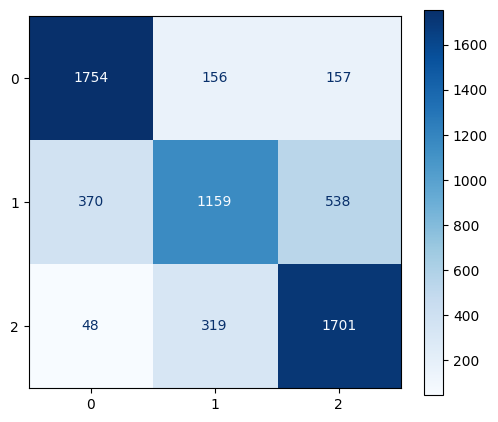

In [ ]:
from sklearn.metrics import  ConfusionMatrixDisplay

# Generar matriz de confusión
cm = confusion_matrix(y_test, y_predicted)

# Etiquetas legibles de tus clases (en el orden correcto: 0 → severa, 1 → moderada, 2 → normal)
clases = ['0', '1','2']

# Mostrar gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Blues', ax=ax, values_format='d', colorbar=True)

ax.set_title("Matriz de Confusión - Modelo Random Forest", fontsize=12)
ax.set_xlabel("Predicción")
ax.set_ylabel("Etiqueta Real")
plt.tight_layout()
plt.show()
